# Overview
- nb015の改良
- focal loss を導入

In [1]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

d04f7d4


# Const

In [2]:
# basic
DEBUG = False 
NB = '019'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
SAVE_DIR = f'../data_ignore/output_nb/nb{NB}/'

In [3]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 45

dataset:
  name: 
  params:
    
split:
  name: MultiStratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: SmoothLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [4]:
import os
import time
import yaml
import random
import numpy as np
import pandas as pd
from glob import glob
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [5]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [6]:
def preprocess(df_):
    df = df_.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df

def remove_ctl_cp(features_, target_):
    features = features_.copy()
    target = target_.copy()
#     bools = features['cp_type'] != 'ctl_vehicle'
    bools = features['cp_type'] != 1
    features = features[bools].reset_index(drop=True)
    features = features.drop(['cp_type'], axis=1).values
    target = target[bools].reset_index(drop=True).values
    return features, target

def add_ctl_cp_oof(oof):
    oof_new = np.zeros_like(train_targets).astype(float)
    bools = train_features['cp_type'] != 'ctl_vehicle'
    oof_new[bools, :] = oof
    return oof_new

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, _X_valid, y_valid):
        X_valid = pd.DataFrame(_X_valid, columns=FEAT_COLUMNS)
        self.n_feat = len(X_valid.columns)
        
        val_set = MoaDataset(_X_valid, y_valid, mode='train')
        dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
        y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
        
        
        self.base_score = self.metric(y_valid, y_valid_pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(progress_bar(X_valid.columns)):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            
#             y_valid_pred = self.model.predict(df_perm)
            val_set = MoaDataset(df_perm.values, y_valid, mode='train')
            dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
            y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
            
            score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')
        

class FocalLoss2d(nn.modules.loss._WeightedLoss):
    '''
    https://github.com/andrijdavid/FocalLoss/blob/master/focalloss.py
    '''

    def __init__(self, gamma=2, weight=None, size_average=None, ignore_index=-100,
                 reduce=None, reduction='mean', balance_param=0.25):
        super(FocalLoss2d, self).__init__(weight, size_average, reduce, reduction)
        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        # inputs and targets are assumed to be BatchxClasses
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)
        
        weight = Variable(self.weight)
           
        # compute the negative likelyhood
        logpt = - F.binary_cross_entropy_with_logits(input, target, pos_weight=weight, reduction=self.reduction)
        pt = torch.exp(logpt)

        # compute the loss
        focal_loss = -( (1-pt)**self.gamma ) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [7]:
class MoaModel(nn.Module):
    def __init__(self, n_input, n_output):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(n_input)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(n_input, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
#         self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, n_output))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x_raw = self.dense3(x)
        x_sigmoid = F.sigmoid(x_raw)
        
        return x_sigmoid, x_raw

In [8]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

In [9]:
def mean_log_loss(y_true, y_pred):
    metrics = []
#     for i in range(y_true.shape[1]):
#         metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
#     return np.mean(metrics)
    y_true =  y_true.astype(np.float64).ravel()
    y_pred =  y_pred.astype(np.float64).ravel()
    return log_loss(y_true, y_pred, labels=[0, 1])

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.001):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [10]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
#         self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         if not DEBUG:
        torch.save(model.state_dict(), self.path)
#         self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss

In [11]:
def train_model(model, device, train_loader, optimizer, scheduler, criterion):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            pred_sigmoid, pred_raw = model(x)
            loss = criterion(pred_raw, y)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() / len(train_loader)
    scheduler.step()
    return running_loss

def get_epoch_loss_score(model, device, valid_loader, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
            loss = criterion(pred_raw, y)
        running_loss += loss.item() / len(valid_loader)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    _mean_log_loss = mean_log_loss(targets, preds)
    return running_loss, _mean_log_loss, preds

def get_epoch_pred(model, device, valid_loader):
    model.eval()
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    return preds

In [12]:
def run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=True):
    device = torch.device("cuda")
    model = ModelClass(shape[0], shape[1]).to(device)
#     model = ModelClass(train.shape[1], ).to(device)
    early_stopping = EarlyStopping(patience=15, verbose=show_log, path=checkpoint_path)
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    scheduler = optim.lr_scheduler.__getattribute__(settings['scheduler']['name'])(
        optimizer, **settings['scheduler']['params'])
    
    best_valid_loss = np.inf
    best_mean_log_loss = np.inf
    best_preds = 0
    val_losses = []
    trn_losses = []
    for epoch in range(n_epochs):
        train_loss =  train_model(model, device, dataloaders['train'], optimizer, scheduler, criterion)
        valid_loss, _mean_log_loss, preds = get_epoch_loss_score(model, device, dataloaders['val'], criterion, optimizer)

        trn_losses.append(train_loss)
        val_losses.append(valid_loss)
        if show_log:
            print(f"Epoch {str(epoch+1).zfill(2)}/{n_epochs }   loss: {train_loss:5.5f}   val_loss: {valid_loss:5.5f}   mean_log_loss: {_mean_log_loss:5.5f}")
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_mean_log_loss = _mean_log_loss
            best_preds = preds
    return best_mean_log_loss, best_preds, trn_losses, val_losses

def run(splitter, train, targets, ModelClass, show_log=True, pi=False):
    mean_log_loss_list = []
    oof = np.zeros_like(targets).astype(float)
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
        print('-'*100)
        print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
        print('-'*100)
        X_trn, X_val = train[idx_trn], train[idx_val]
        y_trn, y_val = targets[idx_trn], targets[idx_val]

        train_set = MoaDataset(X_trn, y_trn, mode='train')
        val_set = MoaDataset(X_val, y_val, mode='train')

        dataloaders = {
            'train': DataLoader(train_set, **settings['loader']['train']),
            'val': DataLoader(val_set, **settings['loader']['val']),
        }

        checkpoint_path = f'{SAVE_DIR}Fold{n+1}of{n_splits}.pt'
        shape = (X_trn.shape[1], y_trn.shape[1])
        best_mean_log_loss, best_preds, trn_losses, val_losses =  run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=show_log)

        # result
        print(f':: best mean_log_loss: {best_mean_log_loss:5.5f} ::')
        mean_log_loss_list.append(best_mean_log_loss)
        oof[idx_val, :] = best_preds
        
        # permutation importance
        if pi:
            device = torch.device("cuda")
            model = ModelClass(shape[0], shape[1]).to(device)
            state_dict = torch.load(checkpoint_path)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            pi = permutation_importance(model, mean_log_loss) # model と metric を渡す
            pi.compute(X_val, y_val)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
    #         pi.show_permutation_importance(score_type='loss')
        
        # plot
        if show_log:
            x = np.arange(1, len(trn_losses)+1)
            plt.figure(figsize=(12, 7))
            plt.plot(x[1:], trn_losses[1:], '--.', label='train')
            plt.plot(x[1:], val_losses[1:], '--.', label='valid')
            plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
            plt.legend()
            plt.show()
        print('\n')
    
    if pi:
        # permutation score
        plt.figure(figsize=(15, int(0.25*len(FEAT_COLUMNS))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=True)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()
    return mean_log_loss_list, oof, df_pi

# Preparation

set

In [13]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])
sns.set()
sns.set_context('talk')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [14]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [15]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
# test_features = pd.read_csv(PATH_TEST)

# ss = pd.read_csv(PATH_SUB)

In [16]:
# step_row = 100
end_col = 10
step_row = 10
# step_row = 4
# step_row = 2
if DEBUG:
    print(':: debug mode ::')
    train_features = train_features.iloc[::step_row, :end_col]
    train_targets = train_targets.iloc[::step_row, :]
#     test_features = test_features.iloc[::100, :]

<br>

preprocess

In [17]:
mask_trt = (train_features['cp_type'] == 'trt_cp').values
train = preprocess(train_features)
FEAT_COLUMNS = train_features.columns[2:]
# test = preprocess(test_features).values

del train_targets['sig_id']

target_cols = [col for col in train_targets.columns]
train, targets = remove_ctl_cp(train, train_targets)
# train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
# train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [18]:
print(f'train shape:         {train.shape}')
# print(f'test shape:          {test.shape}')
print(f'train_targets shape: {targets.shape}')

train shape:         (21948, 874)
train_targets shape: (21948, 206)


# Create model

In [19]:
n_splits = settings['split']['params']['n_splits']
n_epochs = settings['globals']['num_epochs']
splitter = MultilabelStratifiedKFold(**settings['split']['params'])
device = settings['globals']['device']
# criterion = criterion_ = nn.__getattribute__(
#     settings['loss']['name'])(**settings['loss']['params'])
criterion = SmoothBCEwLogits(**settings['loss']['params'])

----------------------------------------------------------------------------------------------------
:: start fold 1/5 at Tue Nov  3 18:02:15 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.41301   val_loss: 0.06944   mean_log_loss: 0.06801
Validation loss decreased (inf --> 0.069442).  Saving model ...
Epoch 02/45   loss: 0.03822   val_loss: 0.02536   mean_log_loss: 0.02290
Validation loss decreased (0.069442 --> 0.025356).  Saving model ...
Epoch 03/45   loss: 0.02548   val_loss: 0.02376   mean_log_loss: 0.02109
Validation loss decreased (0.025356 --> 0.023764).  Saving model ...
Epoch 04/45   loss: 0.02421   val_loss: 0.02319   mean_log_loss: 0.02039
Validation loss decreased (0.023764 --> 0.023190).  Saving model ...
Epoch 05/45   loss: 0.02356   val_loss: 0.02274   mean_log_loss: 0.01989
Validation loss decreased (0.023190 --> 0.022745).  Saving model ...
Epoch 06/45   loss: 0.02314   val_loss: 0.02

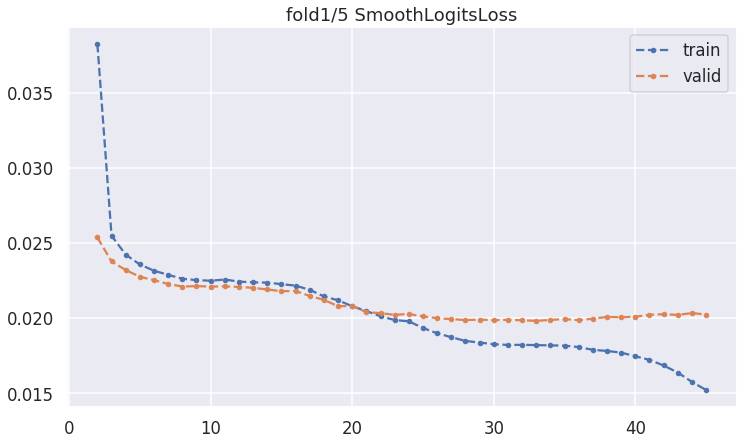



----------------------------------------------------------------------------------------------------
:: start fold 2/5 at Tue Nov  3 18:12:55 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.41633   val_loss: 0.06609   mean_log_loss: 0.06463
Validation loss decreased (inf --> 0.066089).  Saving model ...
Epoch 02/45   loss: 0.03858   val_loss: 0.02565   mean_log_loss: 0.02320
Validation loss decreased (0.066089 --> 0.025652).  Saving model ...
Epoch 03/45   loss: 0.02556   val_loss: 0.02394   mean_log_loss: 0.02125
Validation loss decreased (0.025652 --> 0.023941).  Saving model ...
Epoch 04/45   loss: 0.02427   val_loss: 0.02317   mean_log_loss: 0.02038
Validation loss decreased (0.023941 --> 0.023171).  Saving model ...
Epoch 05/45   loss: 0.02349   val_loss: 0.02265   mean_log_loss: 0.01977
Validation loss decreased (0.023171 --> 0.022648).  Saving model ...
Epoch 06/45   loss: 0.02317   val_loss: 0.

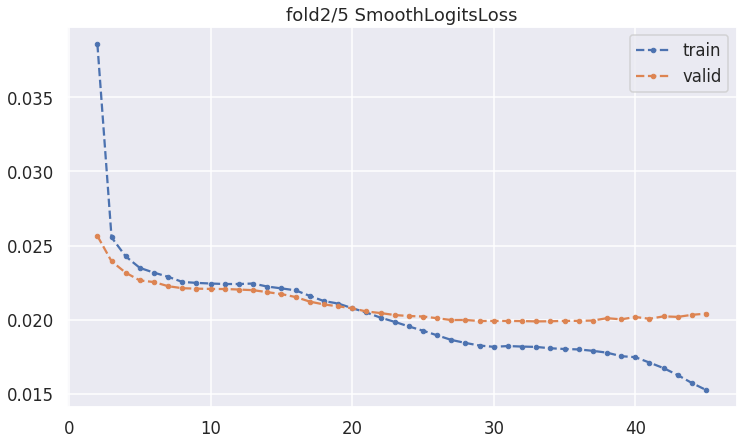



----------------------------------------------------------------------------------------------------
:: start fold 3/5 at Tue Nov  3 18:23:31 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.38926   val_loss: 0.06413   mean_log_loss: 0.06261
Validation loss decreased (inf --> 0.064134).  Saving model ...
Epoch 02/45   loss: 0.03745   val_loss: 0.02566   mean_log_loss: 0.02322
Validation loss decreased (0.064134 --> 0.025664).  Saving model ...
Epoch 03/45   loss: 0.02587   val_loss: 0.02358   mean_log_loss: 0.02088
Validation loss decreased (0.025664 --> 0.023576).  Saving model ...
Epoch 04/45   loss: 0.02427   val_loss: 0.02298   mean_log_loss: 0.02018
Validation loss decreased (0.023576 --> 0.022979).  Saving model ...
Epoch 05/45   loss: 0.02358   val_loss: 0.02251   mean_log_loss: 0.01965
Validation loss decreased (0.022979 --> 0.022508).  Saving model ...
Epoch 06/45   loss: 0.02317   val_loss: 0.

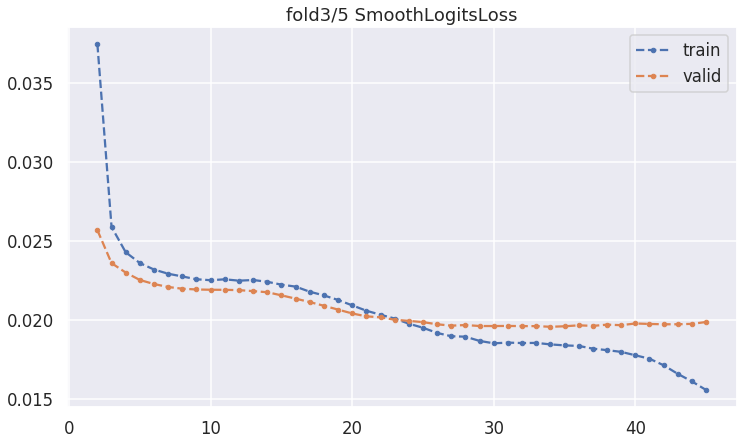



----------------------------------------------------------------------------------------------------
:: start fold 4/5 at Tue Nov  3 18:34:03 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.40164   val_loss: 0.06299   mean_log_loss: 0.06154
Validation loss decreased (inf --> 0.062993).  Saving model ...
Epoch 02/45   loss: 0.03751   val_loss: 0.02552   mean_log_loss: 0.02309
Validation loss decreased (0.062993 --> 0.025522).  Saving model ...
Epoch 03/45   loss: 0.02554   val_loss: 0.02374   mean_log_loss: 0.02108
Validation loss decreased (0.025522 --> 0.023735).  Saving model ...
Epoch 04/45   loss: 0.02435   val_loss: 0.02311   mean_log_loss: 0.02033
Validation loss decreased (0.023735 --> 0.023113).  Saving model ...
Epoch 05/45   loss: 0.02363   val_loss: 0.02268   mean_log_loss: 0.01984
Validation loss decreased (0.023113 --> 0.022677).  Saving model ...
Epoch 06/45   loss: 0.02317   val_loss: 0.

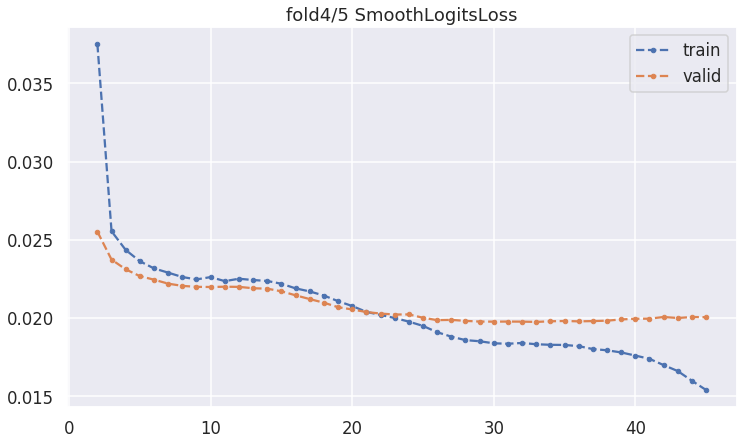



----------------------------------------------------------------------------------------------------
:: start fold 5/5 at Tue Nov  3 18:44:42 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.39843   val_loss: 0.06220   mean_log_loss: 0.06071
Validation loss decreased (inf --> 0.062202).  Saving model ...
Epoch 02/45   loss: 0.03730   val_loss: 0.02567   mean_log_loss: 0.02317
Validation loss decreased (0.062202 --> 0.025674).  Saving model ...
Epoch 03/45   loss: 0.02554   val_loss: 0.02371   mean_log_loss: 0.02096
Validation loss decreased (0.025674 --> 0.023709).  Saving model ...
Epoch 04/45   loss: 0.02415   val_loss: 0.02310   mean_log_loss: 0.02025
Validation loss decreased (0.023709 --> 0.023099).  Saving model ...
Epoch 05/45   loss: 0.02356   val_loss: 0.02280   mean_log_loss: 0.01988
Validation loss decreased (0.023099 --> 0.022801).  Saving model ...
Epoch 06/45   loss: 0.02308   val_loss: 0.

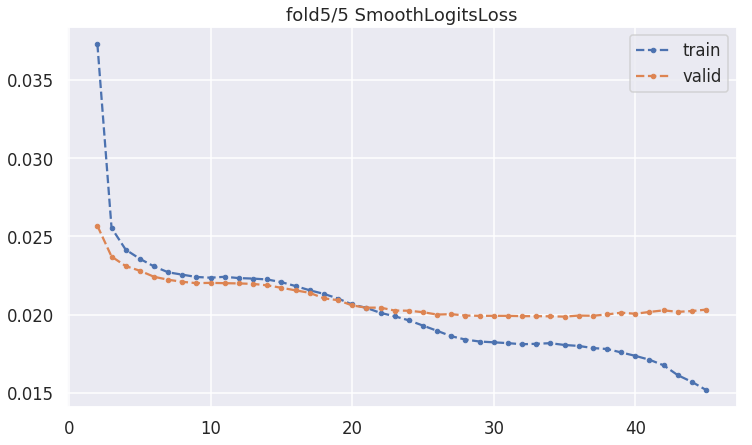

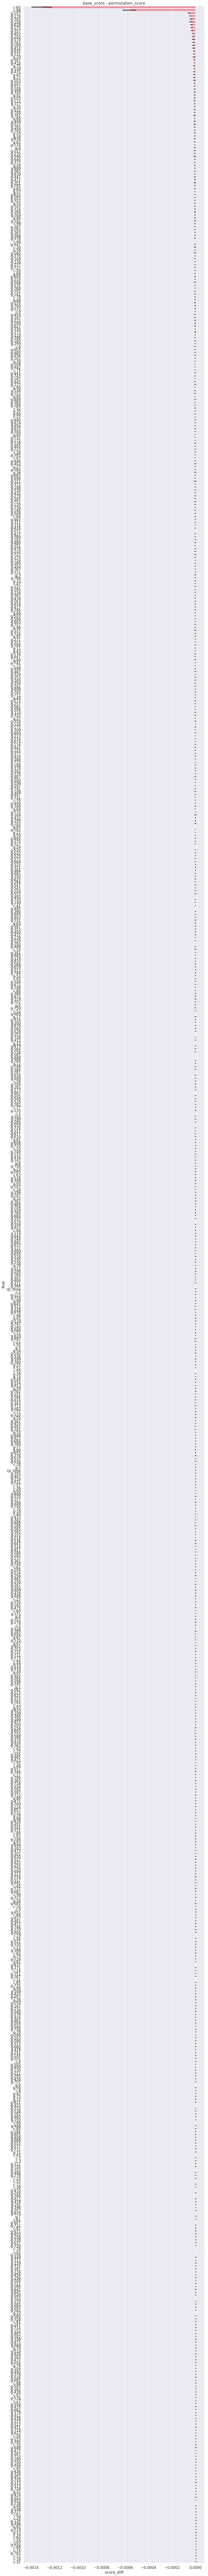

----------------------------------------------------------------------------------------------------
mean_log_loss(all fold): 0.016462 +- 0.000128
mean_log_loss(oof):      0.015172
----------------------------------------------------------------------------------------------------
CPU times: user 13min 36s, sys: 34min 26s, total: 48min 2s
Wall time: 53min 32s


In [20]:
%%time
mean_log_loss_list, _oof, df_pi = run(splitter, train, targets, MoaModel, show_log=True, pi=True)
# result
mean_mean_log_loss = np.mean(mean_log_loss_list)
std_mean_log_loss = np.std(mean_log_loss_list)
oof = add_ctl_cp_oof(_oof)
oof_score = mean_log_loss(train_targets.values, oof)
print('-'*100)
print(f"mean_log_loss(all fold): {mean_mean_log_loss:5.6f} +- {std_mean_log_loss:5.6f}")
print(f"mean_log_loss(oof):      {oof_score:5.6f}")
print('-'*100)

# Save oof

In [21]:
_df_oof = pd.DataFrame(_oof, columns=target_cols)
_df_oof['fold'] = -1
for i, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
    _df_oof.iloc[idx_val, -1] = i + 1

In [22]:
df_oof = pd.DataFrame(oof, columns=target_cols)
df_oof['fold'] = -1
df_oof['fold'][mask_trt] = _df_oof['fold'].values

In [23]:
save_path = f'{SAVE_DIR}oof.csv'
df_oof.to_csv(save_path, index=False)

# Save permutation importance

In [25]:
save_path = f'{SAVE_DIR}permutation_importance.csv'
save_path

'../data_ignore/output_nb/nb015/permutation_importance.csv'

In [26]:
df_pi.to_csv(save_path, index=False)